In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [4]:
import yolov1
from yolov1.config import parse_config

In [5]:
from yolov1.data.dataset import YOLODataset
from yolov1.utils.vis import draw_boxes_pil, draw_boxes_tensor
from yolov1.utils.general import decode_labels

## config

In [6]:
import pprint

In [7]:
def load_config():
    config_path = "../yolov1/src/yolov1/configs/default.yaml"
    config = parse_config(config_file=config_path)
    pprint.pp(config.dict())
    return config

In [124]:
config = load_config()

{'data': {'root': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data',
          'train': 'train',
          'val': 'valid',
          'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'],
          'augmentations': {'apply': True,
                            'horizontal_flip': 0.5,
                            'color_jitter': 1.0,
                            'shift_scale_rotate': 1.0,
                            'random_crop': 1.0,
                            'random_crop_dims': (224.0, 224.0),
                            'gaussian_noise': 0.8}},
 'training': {'epochs': 300,
              'dls_kwargs': {'pin_memory': True,
                             'batch_size': 32,
                             'drop_last': True,
                             'num_workers': 2},
              'optim_kwargs': {'lr': 0.005, 'weight_decay': 0.0005},
              'checkpoints_dir': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints',
              'save_freq':

## dataset

In [127]:
train_ds = YOLODataset(config, mode="train")

Reloading 'yolov1.data.augmentations'.
2024-05-11T08:44:16.887717Z [info     ] Loaded 878 samples             func_name=get_data lineno=65


In [128]:
val_ds = YOLODataset(config, mode="valid")

2024-05-11T08:44:18.787068Z [info     ] Loaded 250 samples             func_name=get_data lineno=65


In [129]:
len(train_ds[2])

2

In [142]:
sample = train_ds[4]

In [143]:
sample[0].shape

torch.Size([3, 224, 224])

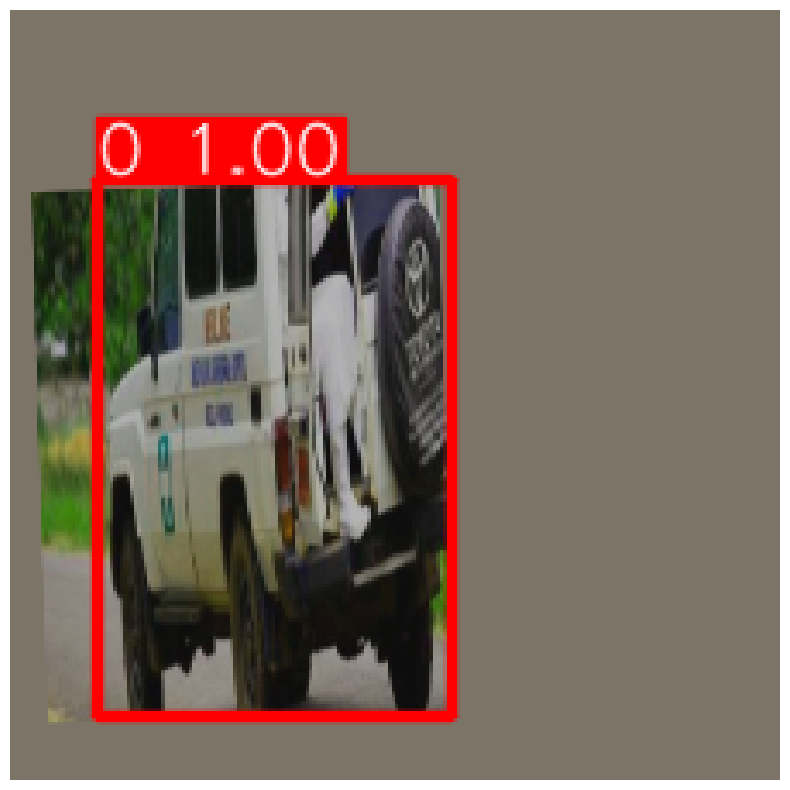

In [144]:
draw_boxes_tensor(
    sample[0],
    decode_labels(sample[1], config.model.S, config.model.B, config.model.nc))

In [95]:
val_ds = YOLODataset(config, mode="val")

2024-05-11T08:33:55.334059Z [info     ] Loaded 250 samples             func_name=get_data lineno=65


## dataloader

In [124]:
train_dataloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.training.batch_size,
        shuffle=True,
        num_workers=config.training.num_workers,
    )
# val_dataloader = torch.utils.data.DataLoader(
#     val_ds,
#     batch_size=config.training.batch_size,
#     shuffle=False,
#     num_workers=config.training.num_workers
# )

Reloading 'yolov1.data.dataset'.


## arch

In [14]:
# from yolov1.models.arch import YOLOv1

In [15]:
# model = YOLOv1(config.model)

## train

In [177]:
config = load_config()

{'data': {'root': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data',
          'train': 'train',
          'val': 'valid',
          'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'],
          'augmentations': {'apply': True,
                            'horizontal_flip': 0.5,
                            'color_jitter': 1.0,
                            'shift_scale_rotate': 0.9,
                            'random_crop': 1.0,
                            'random_crop_dims': (224.0, 224.0),
                            'gaussian_noise': 0.25}},
 'training': {'epochs': 300,
              'dls_kwargs': {'pin_memory': True,
                             'batch_size': 32,
                             'drop_last': True,
                             'num_workers': 2},
              'optim_kwargs': {'lr': 0.03, 'weight_decay': 0.0005},
              'checkpoints_dir': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints',
              'save_freq':

In [178]:
from yolov1.train import main

In [179]:
main(config)

2024-05-11T10:59:46.733030Z [info     ] Loaded 878 samples             func_name=get_data lineno=65
2024-05-11T10:59:46.735720Z [info     ] Loaded 250 samples             func_name=get_data lineno=65
Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-11T10:59:47.726046Z [info     ] Loaded model successfully with 63565332 trainable params func_name=main lineno=69
2024-05-11T10:59:51.560874Z [info     ] [1/300] Train Loss: {'total': 1276.697640878183, 'coord': 765.4655015733507, 'obj': 91.95879787868924, 'noobj': 235.69579308121294, 'class': 183.57754601372613} func_name=main lineno=84
2024-05-11T10:59:55.383991Z [info     ] [2/300] Train Loss: {'total': 577.6251740632234, 'coord': 402.49932183159723, 'obj': 83.40239178692853, 'noobj': 12.402143266465929, 'class': 79.3213171782317} func_name=main lineno=84
2024-05-11T10:59:5

KeyboardInterrupt: 

## infer

In [163]:
from yolov1.detect import main as detect_main
from yolov1.data.dataset import InferenceDataset
from yolov1.data.utils import get_dls_for_inference

In [164]:
config.inference.source = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data/valid/images'

In [165]:
config.inference.checkpoint = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/final_epoch_300.pt'

In [169]:
config.inference.conf_th = 0.2

In [170]:
for idx, res in enumerate(detect_main(config)):
    if idx == 1:
        break

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-11T10:57:58.428165Z [info     ] Model loaded successfully      func_name=main lineno=65


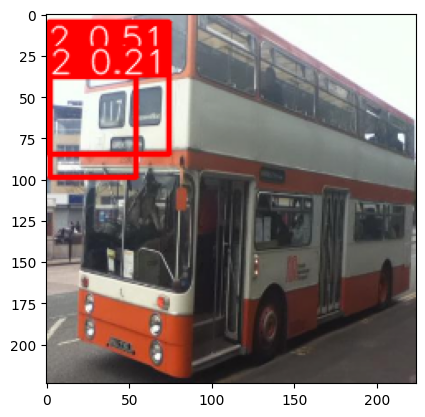

In [175]:
plt.imshow(res["drawn"][3])